# Description

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this dataset from Kaggle competition challenges you to predict the final price of each home.

# Requirements

- Train, validate (using a dedicated validation set) and submit a linear regression model.
- Train, validate (using a dedicated validation set) and submit a random forest regressor model.
- Achieve a score better than 0.14 on the public leaderboard.

# Evaluation criteria

- Public leaderboard score
- How simple is the model
- Code quality

# Data cleaning

In [1]:
import missingno as msno
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)
import seaborn as sns
sns.set_theme()
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [2]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

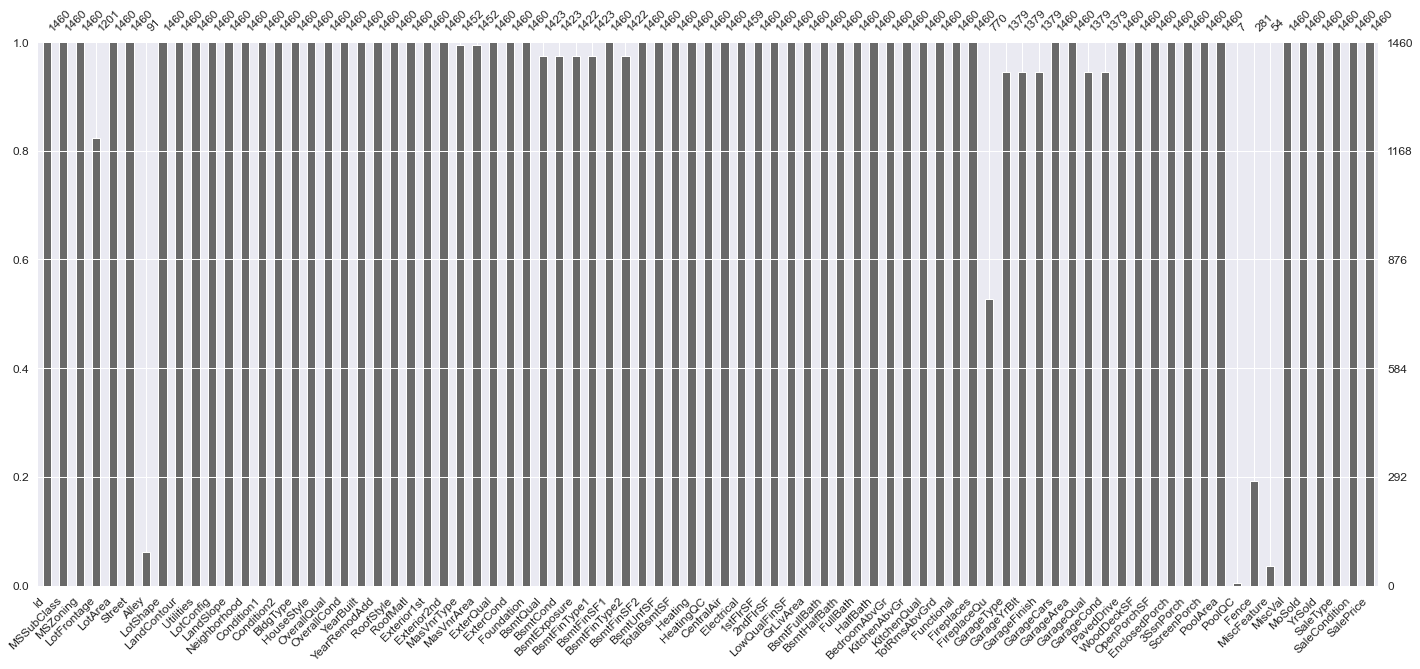

In [3]:
msno.bar(train_data, labels=True, fontsize=12);

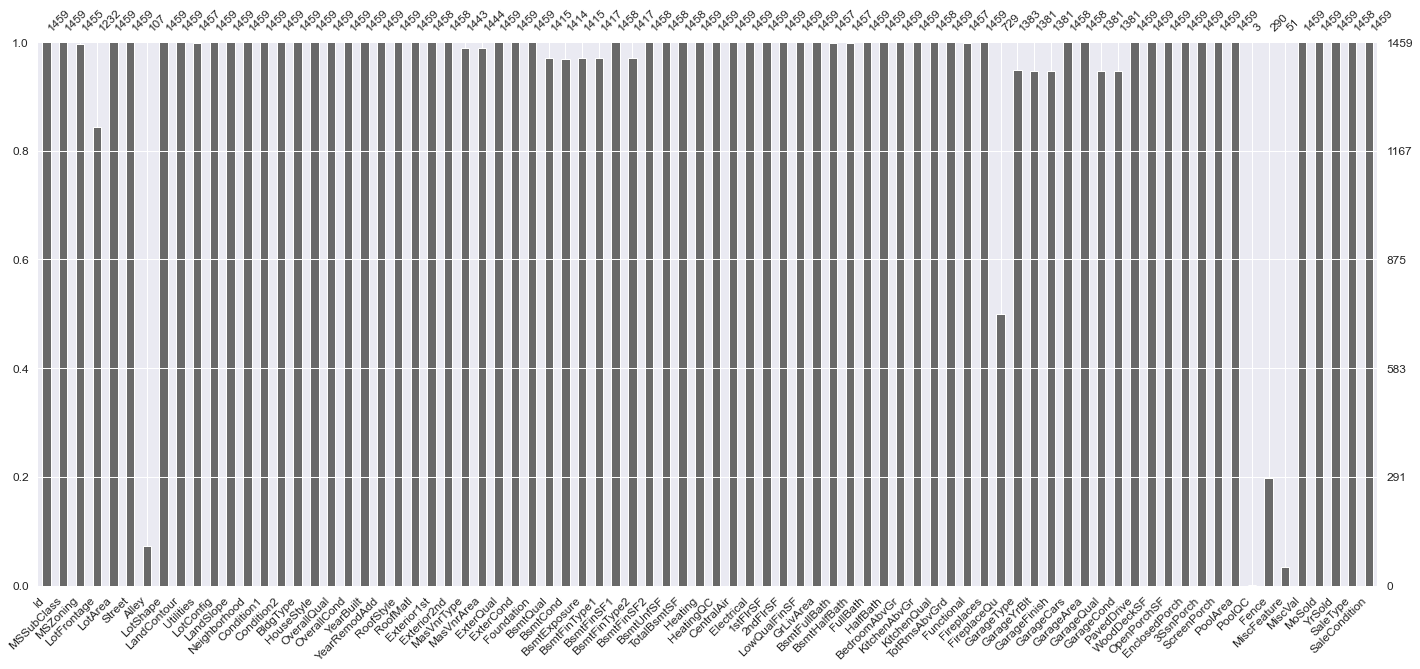

In [4]:
msno.bar(test_data, labels=True, fontsize=12);

In the very beginning I have decided entirely drop Alley, PoolQC, Fence and MiscFeature features because majority of values are missing.

In [5]:
features_to_drop = ["Alley", "PoolQC", "Fence", "MiscFeature"]
cleaned_train_data = train_data.drop(columns=features_to_drop)
cleaned_test_data = test_data.drop(columns=features_to_drop)

Assuming that majority of lot areas in one neighborhood are more or less similar, I have filled missing values in LotFrontage column by most frequent value of particular neighborhood. 

In [19]:
fill_mode = lambda x: x.value_counts().index[0]

cleaned_train_data["LotFrontage"] = cleaned_train_data["LotFrontage"].fillna(cleaned_train_data.groupby("Neighborhood")["LotFrontage"].transform(fill_mode))
cleaned_test_data["LotFrontage"] = cleaned_test_data["LotFrontage"].fillna(cleaned_test_data.groupby("Neighborhood")["LotFrontage"].transform(fill_mode))

In [7]:
print("Most frequent value in MasVnrType column:", cleaned_train_data["MasVnrType"].mode()[0])
print("Most frequent value in MasVnrAre column:", cleaned_train_data["MasVnrArea"].mode()[0])

Most frequent value in MasVnrType column: None
Most frequent value in MasVnrAre column: 0.0


In [8]:
print("Number of most frequent value in MasVnrType column:", cleaned_train_data[cleaned_train_data["MasVnrType"] == "None"].shape[0])
print("Number of most frequent value in MasVnrAre column:", cleaned_train_data[cleaned_train_data["MasVnrArea"] == 0.0].shape[0])

Number of most frequent value in MasVnrType column: 864
Number of most frequent value in MasVnrAre column: 861


More than a half of values in both MasVnrType and MasVnrAre columns are None or 0.0 respectively. Also I made a technical assumption that masonry type depends on RoofStyle, RoofMatl and Exterior1st or vice versa. So the most frequent values of latter features, which also are values of coresponding rows with missing values in MasVnrType and MasVnrAre columns, are None and 0.0.

In [9]:
cleaned_train_data["MasVnrType"] = cleaned_train_data["MasVnrType"].fillna("None")
cleaned_train_data["MasVnrArea"] = cleaned_train_data["MasVnrArea"].fillna(0.0)

cleaned_test_data["MasVnrType"] = cleaned_test_data["MasVnrType"].fillna("None")
cleaned_test_data["MasVnrArea"] = cleaned_test_data["MasVnrArea"].fillna(0.0)

About 40 values are missing which are related to the features of basement and according to data description file this means that the house has no basement, so I have changed these NA values to None.

In [10]:
basement_features = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]

for feature in basement_features:
    cleaned_train_data[feature] = cleaned_train_data[feature].fillna("None")
    cleaned_test_data[feature] = cleaned_test_data[feature].fillna("None")

NA value in the FireplaceQu column means that house has no fireplace so I have changed these NA values to None.

In [11]:
cleaned_train_data["FireplaceQu"] = cleaned_train_data["FireplaceQu"].fillna("None")
cleaned_test_data["FireplaceQu"] = cleaned_test_data["FireplaceQu"].fillna("None")

NA values in features which are related to garage also corresponds that house has no garage, so I have changed these NA values to None.

In [12]:
garage_features = ["GarageType", "GarageYrBlt", "GarageFinish", "GarageQual", "GarageCond"]

for feature in garage_features:
    cleaned_train_data[feature] = cleaned_train_data[feature].fillna("None")
    cleaned_test_data[feature] = cleaned_test_data[feature].fillna("None")

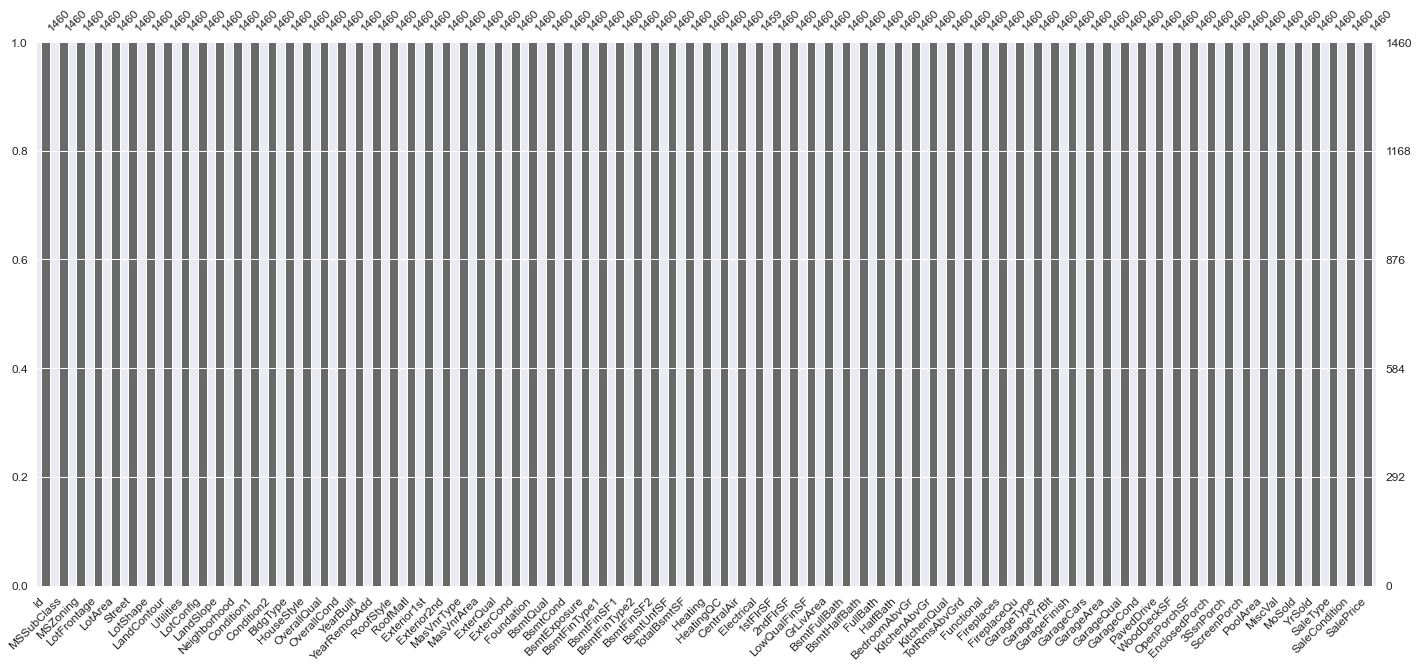

In [21]:
msno.bar(cleaned_train_data, labels=True, fontsize=12);

## Missing values of test set 

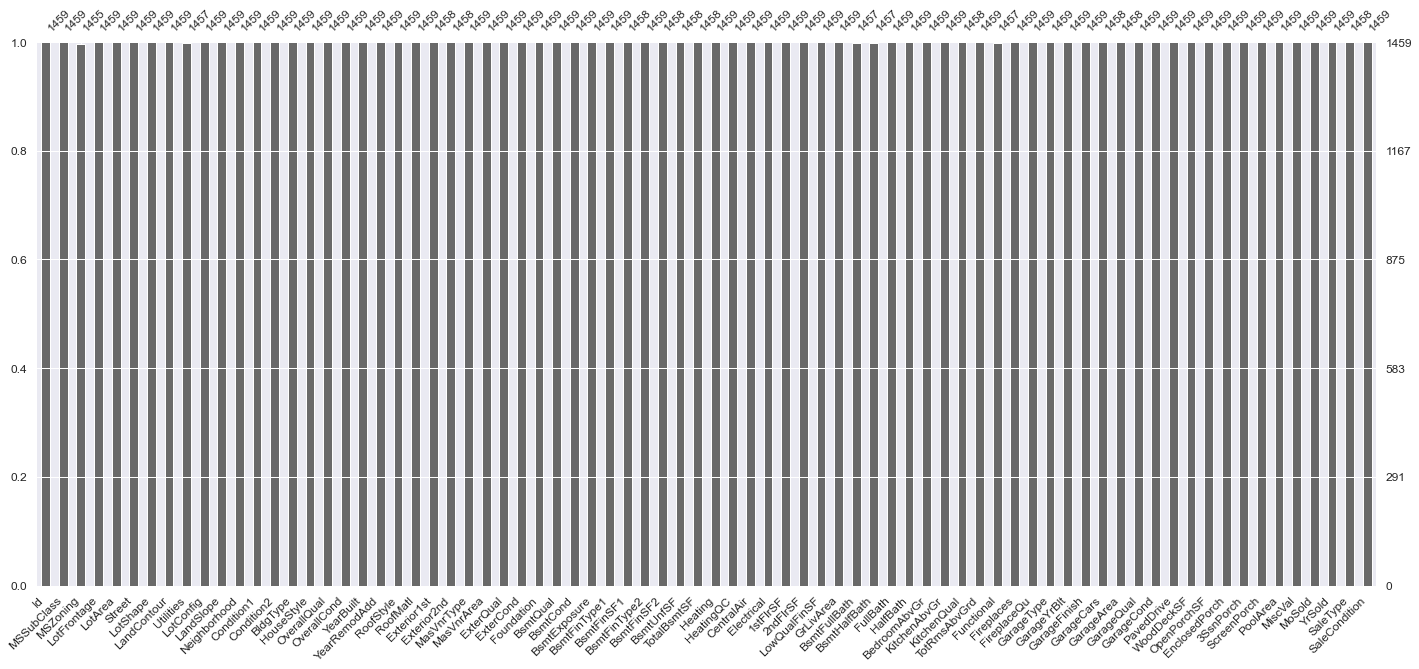

In [22]:
msno.bar(cleaned_test_data, labels=True, fontsize=12);

Some columns in test set are missing just one or two values, so I have simply filled these missing values with most frequent values in those columns.

In [40]:
missing_test_features = []

for column in cleaned_test_data:
    if cleaned_test_data[column].isna().any() == True:
        missing_test_features.append(column)

In [45]:
for feature in missing_test_features:
    cleaned_test_data[feature] = cleaned_test_data[feature].fillna(cleaned_test_data[feature].value_counts().index[0])

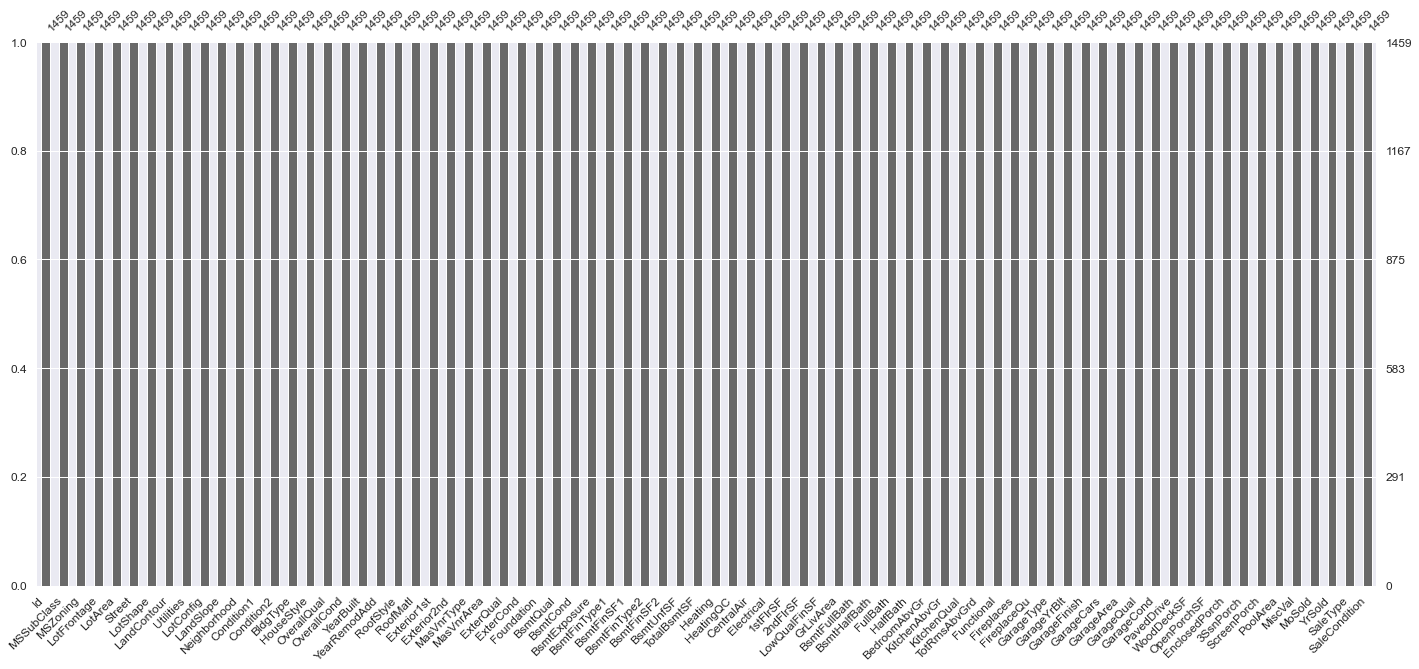

In [46]:
msno.bar(cleaned_test_data, labels=True, fontsize=12);

# Feature engineering

## Feature encoding

### Mapping

Some categorical features have clear order, therefore I have decided to map that values with numbers in sequence. 

In [13]:
cleaned_encoded_data = cleaned_data.copy()

In [14]:
quality_mapping = {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
quality_features = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "HeatingQC"]

for feature in quality_features:
    cleaned_encoded_data[feature] = cleaned_encoded_data[feature].map(quality_mapping)

In [15]:
basement_rating_mapping = {"None": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
basement_rating_features = ["BsmtFinType1", "BsmtFinType2"]

for feature in basement_rating_features:
    cleaned_encoded_data[feature] = cleaned_encoded_data[feature].map(basement_rating_mapping)

In [16]:
utilities_mapping = {"ELO": 1, "NoSeWa": 2, "NoSewr": 3, "AllPub": 4}
cleaned_encoded_data["Utilities"] = cleaned_encoded_data["Utilities"].map(utilities_mapping)

In [17]:
central_air_mapping = {"N": 0, "Y": 1}
cleaned_encoded_data["CentralAir"] = cleaned_encoded_data["CentralAir"].map(central_air_mapping)

In [18]:
garage_finish_mapping = {"None": 0, "Unf": 1, "RFn": 2, "Fin": 3}
cleaned_encoded_data["GarageFinish"] = cleaned_encoded_data["GarageFinish"].map(garage_finish_mapping)

In [19]:
cleaned_encoded_data["GarageYrBlt"] = cleaned_encoded_data["GarageYrBlt"].replace("None", 0)

In [20]:
cleaned_encoded_data["GarageAge"] = cleaned_encoded_data["YrSold"] - cleaned_encoded_data["GarageYrBlt"].astype("int64")

### One-hot encoding

In [21]:
categorical_features = []

for column in cleaned_encoded_data:
    if cleaned_encoded_data[column].dtypes == "object":
        categorical_features.append(column)

In [22]:
cleaned_oh_encoded_data = pd.get_dummies(cleaned_encoded_data, columns=categorical_features)

# Modelling

Kaggle submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price, so I have to convert latter column to logarithmic scale.

In [23]:
cleaned_oh_encoded_data["SalePrice"] = np.log(cleaned_oh_encoded_data["SalePrice"])

In [24]:
target = "SalePrice"
features = [column for column in cleaned_oh_encoded_data if column != target]

X = cleaned_oh_encoded_data[features]
y = cleaned_oh_encoded_data[target] 


## Linear regression

In [27]:
linear_regression = LinearRegression()
linear_scores = cross_val_score(linear_regression, X, y, scoring="neg_root_mean_squared_error")
print("Linear regression RMSE:", linear_scores.mean())

Linear regression RMSE: -0.15207813240325738


In [ ]:
linear_regression.fit(X, y)
linear_predictions = linear_regression

## Random forest regressor

In [46]:
random_forest = RandomForestRegressor()
random_forest_scores = cross_val_score(random_forest, X, y, scoring="neg_root_mean_squared_error")
print("Random forest regressor RMSE:", random_forest_scores.mean())

Linear regression RMSE: -0.14219399365115137


# Fails

## Data shuffling

In [43]:
shuffled_data = cleaned_oh_encoded_data.sample(frac=1)

X_shuffled = cleaned_oh_encoded_data[features]
y_shuffled = cleaned_oh_encoded_data[target] 

In [44]:
shuffled_linear_scores = cross_val_score(linear_regression, X_shuffled, y_shuffled, scoring="neg_root_mean_squared_error")
print("Linear regression RMSE with shuffled data:", shuffled_linear_scores.mean())

Linear regression RMSE with shuffled data: -0.15207813240325738


Shuffling data before cross validation doesn't improve score.